In [1]:
import geopandas as gpd
from sodapy import Socrata
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import matplotlib.dates as mdates


from hidden_config import Config

Use API key and credentials to query Socrata database

In [88]:
url = "data.cityofchicago.org"
client = Socrata(url,
                 Config.API_KEY,
                 username=Config.USERNAME,
                 password=Config.PASSWORD)

red_light_violations_uri = 'spqx-js37'
speed_camera_violations_uri = 'hhkd-xvj4'

# defaul limit is 1000
red_light_violations_list = client.get(red_light_violations_uri, limit=1000000)
speed_camera_violations_list = client.get(speed_camera_violations_uri, limit=1000000)

red_light_violations_df = pd.DataFrame(red_light_violations_list)
speed_camera_violations_df = pd.DataFrame(speed_camera_violations_list)


### Data Cleansing
Cast the columns to their proper data types

In [89]:
speed_camera_violations_df['violations'] = speed_camera_violations_df['violations'].astype(float)
red_light_violations_df['violations'] = red_light_violations_df['violations'].astype(float)

speed_camera_violations_df['violation_date'] = pd.to_datetime(speed_camera_violations_df['violation_date'])
red_light_violations_df['violation_date'] = pd.to_datetime(red_light_violations_df['violation_date'])

speed_camera_violations_df['violation_day_of_week'] = speed_camera_violations_df['violation_date'].dt.strftime('%A')
red_light_violations_df['violation_day_of_week'] = pd.to_datetime(red_light_violations_df['violation_date']).dt.strftime('%A')

Drop the metadata columns the database adds

In [90]:
speed_cols_to_drop = speed_camera_violations_df.filter(like='@computed', axis=1)
speed_camera_violations_df.drop(columns=speed_cols_to_drop, axis=1, inplace=True)

red_light_cols_to_drop = red_light_violations_df.filter(like='@computed', axis=1)
red_light_violations_df.drop(columns=red_light_cols_to_drop, axis=1, inplace=True)

### Data Summary


In [91]:
print(f"There are {speed_camera_violations_df['camera_id'].nunique()} speed cameras in the city. They issue {round(speed_camera_violations_df.groupby('violation_date')['violations'].mean().mean(),1)} tickets per day")
print(f"There are {red_light_violations_df['camera_id'].nunique()} red light cameras in the city. They issue {round(red_light_violations_df.groupby('violation_date')['violations'].mean().mean(),1)} tickets per day")

There are 181 speed cameras in the city. They issue 41.1 tickets per day
There are 365 red light cameras in the city. They issue 6.2 tickets per day


Consider the distribution of how many cameras are issuing tickets

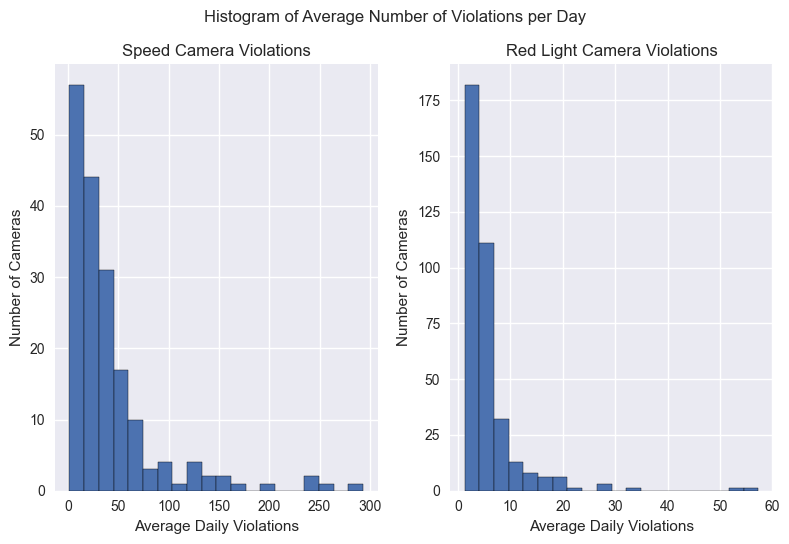

In [92]:
plt.style.use('seaborn-v0_8')
fig, ax = plt.subplots(1, 2)

average_speed_violations_per_camera_per_day = speed_camera_violations_df.groupby(['camera_id', 'violation_date'])['violations'].sum().groupby('camera_id').mean()
average_red_light_violations_per_camera_per_day = red_light_violations_df.groupby(['camera_id', 'violation_date'])['violations'].sum().groupby('camera_id').mean()

ax[0].hist(average_speed_violations_per_camera_per_day, bins=20, edgecolor='black')
ax[1].hist(average_red_light_violations_per_camera_per_day, bins=20, edgecolor='black')

ax[0].set_xlabel('Average Daily Violations')
ax[0].set_ylabel('Number of Cameras')
ax[0].set_title('Speed Camera Violations')

ax[1].set_xlabel('Average Daily Violations')
ax[1].set_ylabel('Number of Cameras')
ax[1].set_title('Red Light Camera Violations')

fig.suptitle('Histogram of Average Number of Violations per Day')
plt.tight_layout()
plt.show()

In [93]:
camera_id_of_highest_frequency = red_light_violations_df.groupby(['camera_id', 'violation_date'])['violations'].sum().groupby('camera_id').mean().sort_values().index[-1]
highest_average_frequency = round(red_light_violations_df.groupby(['camera_id', 'violation_date'])['violations'].sum().groupby('camera_id').mean().sort_values().values[-1],1)
intersection_of_highest_red_light_violations = red_light_violations_df[red_light_violations_df['camera_id'] == camera_id_of_highest_frequency]['intersection'].unique()[0]

print(f"We can see there is an outlier for the red light camera violations. \
      \nOne camera is averaging {highest_average_frequency} violations per day even though the average for the rest of the dataset is {round(red_light_violations_df.groupby('violation_date')['violations'].mean().mean(),1)} violations per day. \
      \nThis intersection is {intersection_of_highest_red_light_violations}")

We can see there is an outlier for the red light camera violations.       
One camera is averaging 57.4 violations per day even though the average for the rest of the dataset is 6.2 violations per day.       
This intersection is CICERO AND I55


### Temporal Analysis
Let's see how the number of violations trends over time.

Chicago is constantly installing more cameras. We can see how many unique camera_ids are present in each data set per month. This analysis assumes that each camera will have at least 1 violation per month in order to be represented in this analysis.

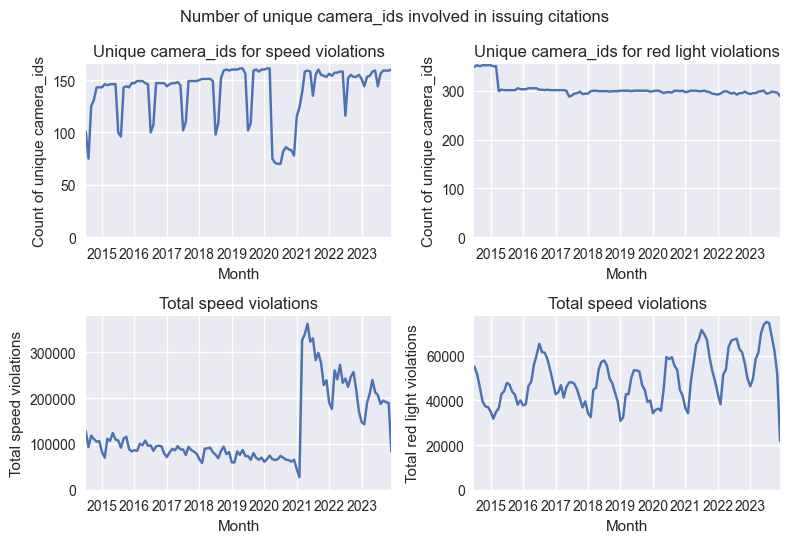

In [131]:
# speed_camera_violations_df['violation_month'] = speed_camera_violations_df
speed_camera_violations_df['violation_month'] = speed_camera_violations_df['violation_date'].dt.to_period('M')
unique_speed_camera_id_counts_per_month = speed_camera_violations_df.groupby('violation_month')['camera_id'].nunique().sort_index()
total_speed_camera_violations_per_month = speed_camera_violations_df.groupby('violation_month')['violations'].sum().sort_index()

red_light_violations_df['violation_month'] = red_light_violations_df['violation_date'].dt.to_period('M')
unique_red_light_camera_id_counts_per_month = red_light_violations_df.groupby('violation_month')['camera_id'].nunique().sort_index()
total_red_light_camera_violations_per_month = red_light_violations_df.groupby('violation_month')['violations'].sum().sort_index()

plt.style.use('seaborn-v0_8')
fig, ax = plt.subplots(2, 2)
unique_speed_camera_id_counts_per_month.plot(kind='line', ax=ax[0][0])
ax[0][0].set_title('Unique camera_ids for speed violations')
ax[0][0].set_xlabel('Month')
ax[0][0].set_ylabel('Count of unique camera_ids')
ax[0][0].set_ylim(0)  # Ensure y-axis starts at 0

total_speed_camera_violations_per_month.plot(kind='line', ax=ax[1][0])
ax[1][0].set_title('Total speed violations')
ax[1][0].set_xlabel('Month')
ax[1][0].set_ylabel('Total speed violations')
ax[1][0].set_ylim(0)  # Ensure y-axis starts at 0

unique_red_light_camera_id_counts_per_month.plot(kind='line', ax=ax[0][1])
ax[0][1].set_title('Unique camera_ids for red light violations')
ax[0][1].set_xlabel('Month')
ax[0][1].set_ylabel('Count of unique camera_ids')
ax[0][1].set_ylim(0)  # Ensure y-axis starts at 0

total_red_light_camera_violations_per_month.plot(kind='line', ax=ax[1][1])
ax[1][1].set_title('Total speed violations')
ax[1][1].set_xlabel('Month')
ax[1][1].set_ylabel('Total red light violations')
ax[1][1].set_ylim(0)  # Ensure y-axis starts at 0

plt.suptitle('Number of unique camera_ids involved in issuing citations')
plt.tight_layout()


In [114]:
# pd.set_option('display.max_rows', None)

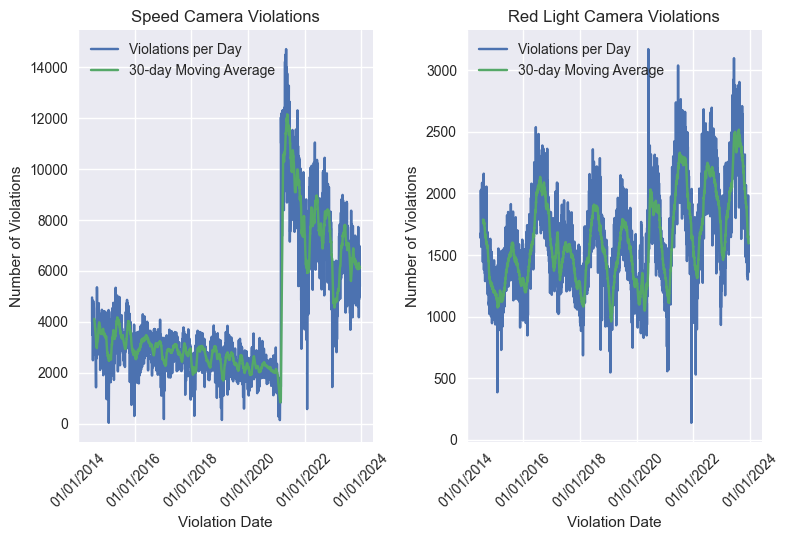

In [115]:
speed_camera_violations_df['30_day_ma'] = speed_camera_violations_df['violations'].rolling(window=30).mean()

plt.style.use('seaborn-v0_8')
fig, ax = plt.subplots(1, 2)

ax[0].plot(speed_camera_violations_df.groupby('violation_date')['violations'].sum(), label='Violations per Day')

speed_camera_daily_sum = pd.DataFrame(speed_camera_violations_df.groupby('violation_date')['violations'].sum())
speed_camera_ma = speed_camera_daily_sum.rolling(window=30).mean()
ax[0].plot(speed_camera_ma['violations'], label='30-day Moving Average')


ax[0].tick_params(axis='x', rotation=45)
ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
ax[0].set_xticks(ax[0].get_xticks()[::2])
ax[0].set_xlabel('Violation Date')
ax[0].set_ylabel('Number of Violations')
ax[0].set_title('Speed Camera Violations')
ax[0].legend()

ax[1].plot(red_light_violations_df.groupby('violation_date')['violations'].sum(), label='Violations per Day')

red_light_daily_sum = pd.DataFrame(red_light_violations_df.groupby('violation_date')['violations'].sum())
red_light_ma = red_light_daily_sum.rolling(window=30).mean()
ax[1].plot(red_light_ma['violations'], label='30-day Moving Average')


ax[1].tick_params(axis='x', rotation=45)
ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
ax[1].set_xticks(ax[1].get_xticks()[::2])
ax[1].set_xlabel('Violation Date')
ax[1].set_ylabel('Number of Violations')
ax[1].set_title('Red Light Camera Violations')
ax[1].legend()
plt.tight_layout()
plt.show()



DoW Analysis

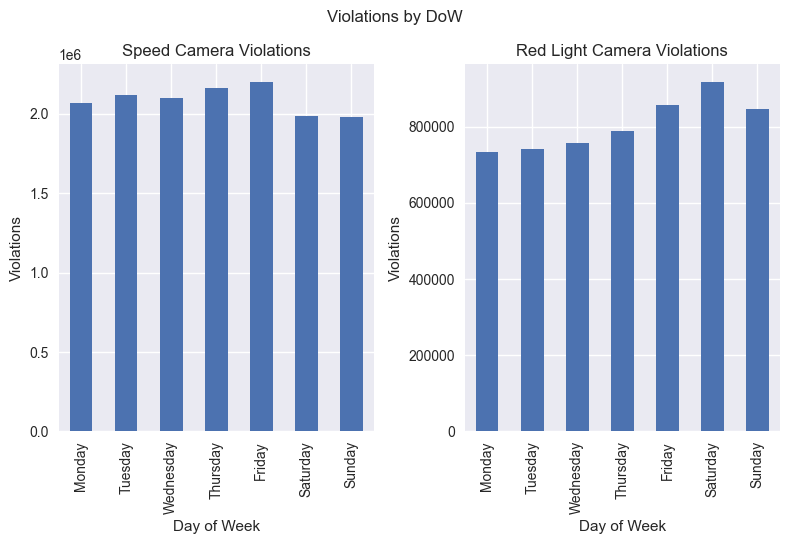

In [116]:
# Sum violations by day of week
speed_camera_violations_by_dow = speed_camera_violations_df.groupby(['violation_day_of_week'])['violations'].sum()

# Do the same for red light cameras
red_light_violations_by_dow = red_light_violations_df.groupby(['violation_day_of_week'])['violations'].sum()

# Create a Categorical data type with the desired order
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
cat_order = pd.CategoricalDtype(categories=day_order, ordered=True)

speed_camera_violations_by_dow.index = speed_camera_violations_by_dow.index.astype(cat_order)
red_light_violations_by_dow.index = red_light_violations_by_dow.index.astype(cat_order)

plt.style.use('seaborn-v0_8')
fig, ax = plt.subplots(1, 2)

speed_camera_violations_by_dow.sort_index().plot(kind='bar', ax=ax[0])
red_light_violations_by_dow.sort_index().plot(kind='bar', ax=ax[1])

ax[0].set_xlabel('Day of Week')
ax[0].set_ylabel('Violations')
ax[0].set_title('Speed Camera Violations')

ax[1].set_xlabel('Day of Week')
ax[1].set_ylabel('Violations')
ax[1].set_title('Red Light Camera Violations')

fig.suptitle('Violations by DoW')
plt.tight_layout()
plt.show()


In [117]:
# Read the GeoJSON data from the boundaries shapefiles. 
chicago_communities = gpd.read_file('chicago_communities')

In [118]:
# Extract the latitude and longitude values from the 'location' column
red_light_violations_df['latitude'] = red_light_violations_df['location'].apply(lambda x: x['latitude'] if isinstance(x, dict) and 'latitude' in x else None)
red_light_violations_df['longitude'] = red_light_violations_df['location'].apply(lambda x: x['longitude'] if isinstance(x, dict) and 'longitude' in x else None)

